In [1]:
import json
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

import pandas as pd 
import numpy as np
import os, sys, email, re

from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [2]:
'''emails = pd.read_csv('emails.csv')'''

"emails = pd.read_csv('emails.csv')"

In [3]:
'''emails.head()'''

'emails.head()'

In [4]:
'''emails.shape'''

'emails.shape'

In [5]:
'''emails.message[1]'''

'emails.message[1]'

In [6]:
'''emails.info()'''

'emails.info()'

In [7]:
'''emails.describe()'''

'emails.describe()'

## Data Preprocessing

In [8]:
#To get the content from email objects
'''
def get_text_from_email(msg):
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append(part.get_payload())
    return ''.join(parts) 
    '''

"\ndef get_text_from_email(msg):\n    parts = []\n    for part in msg.walk():\n        if part.get_content_type() == 'text/plain':\n            parts.append(part.get_payload())\n    return ''.join(parts) \n    "

In [9]:
#To separate multiple email addresses
'''
def split_email_addresses(line):
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    
    else:
        addrs = None
    return addrs '''

"\ndef split_email_addresses(line):\n    if line:\n        addrs = line.split(',')\n        addrs = frozenset(map(lambda x: x.strip(), addrs))\n    \n    else:\n        addrs = None\n    return addrs "

In [10]:
# Parse the emails into a list email objects
'''
messages = list(map(email.message_from_string, emails['message']))
emails.drop('message', axis=1, inplace=True)

# Get fields from parsed email objects
keys = messages[0].keys()

for key in keys:
    emails[key] = [doc[key] for doc in messages]
    
# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))

# Split multiple email addresses
emails['From'] = emails['From'].map(split_email_addresses)
emails['To'] = emails['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails['user'] = emails['file'].map(lambda x:x.split('/')[0])
del messages

emails.head(10) '''

"\nmessages = list(map(email.message_from_string, emails['message']))\nemails.drop('message', axis=1, inplace=True)\n\n# Get fields from parsed email objects\nkeys = messages[0].keys()\n\nfor key in keys:\n    emails[key] = [doc[key] for doc in messages]\n    \n# Parse content from emails\nemails['content'] = list(map(get_text_from_email, messages))\n\n# Split multiple email addresses\nemails['From'] = emails['From'].map(split_email_addresses)\nemails['To'] = emails['To'].map(split_email_addresses)\n\n# Extract the root of 'file' as 'user'\nemails['user'] = emails['file'].map(lambda x:x.split('/')[0])\ndel messages\n\nemails.head(10) "

In [11]:
# Set index and drop columns with two few values
'''
emails = emails.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
emails['Date'] = pd.to_datetime(emails['Date'], infer_datetime_format=True)
emails.dtypes '''

"\nemails = emails.set_index('Message-ID')    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)\n# Parse datetime\nemails['Date'] = pd.to_datetime(emails['Date'], infer_datetime_format=True)\nemails.dtypes "

In [12]:
#Don't need to clean dataset as IBM watson analyser will do it. Might have to do during MODELLING.

'''
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to", "cc", "subject", "http", "from", "sent"))
    exclude = set(string.punctuation)
    
    #lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.
    
'''

'\ndef clean(text):\n    stop = set(stopwords.words(\'english\'))\n    stop.update(("to", "cc", "subject", "http", "from", "sent"))\n    exclude = set(string.punctuation)\n    \n    #lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.\n    \n'

In [13]:
''' emails['content'][10] '''

" emails['content'][10] "

In [14]:
''' tone_df = emails[['content']][:2000] '''

" tone_df = emails[['content']][:2000] "

In [15]:
#new dataset for message content and its tone
#tone_df.to_csv(r'/Users/siddharthsingh/CadenceIQ/tone_Analyzer/tone-content-data.csv')
tone_df = pd.read_csv('tone-content-data.csv')

In [16]:
'''tone_df.head()'''

'tone_df.head()'

In [17]:
'''tone_df.shape'''

'tone_df.shape'

In [18]:
#IBM watson tone analyser API endpoint 
'''
authenticator = IAMAuthenticator('7UkBO29yBlRAuDZzA5s8Nl-IbmlR3mK1yINRazApqitf')
tone_analyzer = ToneAnalyzerV3(
    version='2017-09-21',
    authenticator=authenticator
)
tone_analyzer.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/cd914da7-f09f-4298-862d-d4c6005ac8b3')
'''

"\nauthenticator = IAMAuthenticator('7UkBO29yBlRAuDZzA5s8Nl-IbmlR3mK1yINRazApqitf')\ntone_analyzer = ToneAnalyzerV3(\n    version='2017-09-21',\n    authenticator=authenticator\n)\ntone_analyzer.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/cd914da7-f09f-4298-862d-d4c6005ac8b3')\n"

In [19]:
#Converting column to list. We could also use df['column'].tolist() OR list(tone_df['content'])
'''
text = list(tone_df['content'])
text '''

"\ntext = list(tone_df['content'])\ntext "

In [20]:
'''c = 0
list_tones = [] '''

'c = 0\nlist_tones = [] '

In [21]:
'''
for i in text:
    print(i)
    tone_analysis = tone_analyzer.tone(
        {'text': i},
        content_type='application/json'
    ).get_result()
    
    list_tones.append(json.dumps(tone_analysis, indent=2))
    c+=1
    
tone_df = tone_df.assign(tones = list_tones)
#print(json.dumps(tone_analysis, indent=2))     '''

"\nfor i in text:\n    print(i)\n    tone_analysis = tone_analyzer.tone(\n        {'text': i},\n        content_type='application/json'\n    ).get_result()\n    \n    list_tones.append(json.dumps(tone_analysis, indent=2))\n    c+=1\n    \ntone_df = tone_df.assign(tones = list_tones)\n#print(json.dumps(tone_analysis, indent=2))     "

In [22]:
'''tone_df.head()'''

'tone_df.head()'

In [23]:
'''tone_df.to_csv(r'/Users/siddharthsingh/CadenceIQ/tone_Analyzer/tone-content-data-og.csv')'''

"tone_df.to_csv(r'/Users/siddharthsingh/CadenceIQ/tone_Analyzer/tone-content-data-og.csv')"

In [24]:
#print(json.dumps(tone_analysis, indent=2)) 

In [25]:
#print(tone_analysis['sentences_tone'][1]['tones'][0])

## Accessing JSON data to visualize distribution of Enron dataset tones

In [26]:
og_tone = pd.read_csv('tone-content-data-og.csv')

In [27]:
og_tone['tones'][5]

'{\n  "document_tone": {\n    "tones": [\n      {\n        "score": 0.883404,\n        "tone_id": "analytical",\n        "tone_name": "Analytical"\n      },\n      {\n        "score": 0.994704,\n        "tone_id": "tentative",\n        "tone_name": "Tentative"\n      }\n    ]\n  },\n  "sentences_tone": [\n    {\n      "sentence_id": 0,\n      "text": "Greg,",\n      "tones": []\n    },\n    {\n      "sentence_id": 1,\n      "text": "",\n      "tones": []\n    },\n    {\n      "sentence_id": 2,\n      "text": " How about either next Tuesday or Thursday?",\n      "tones": [\n        {\n          "score": 0.801827,\n          "tone_id": "analytical",\n          "tone_name": "Analytical"\n        },\n        {\n          "score": 0.974201,\n          "tone_id": "tentative",\n          "tone_name": "Tentative"\n        }\n      ]\n    },\n    {\n      "sentence_id": 3,\n      "text": "Phillip",\n      "tones": []\n    }\n  ]\n}'

In [28]:
import json

In [29]:
#To replce \\n with \n. Helps in visaualising JSON data.
og_tone['tones'].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

In [30]:
#Any content with just ONE sentence does NOT have a sentence-id in JSON data.
og_tone.head(10)

,Unnamed: 0,Message-ID,content,tones
0,0,<18782981.1075855378110.JavaMail.evans@thyme>,Here is our forecast\n\n,"{ ""document_tone"": { ""tones"": [ { ..."
1,1,<15464986.1075855378456.JavaMail.evans@thyme>,Traveling to have a business meeting takes the...,"{ ""document_tone"": { ""tones"": [ { ..."
2,2,<24216240.1075855687451.JavaMail.evans@thyme>,test successful. way to go!!!,"{ ""document_tone"": { ""tones"": [ { ..."
3,3,<13505866.1075863688222.JavaMail.evans@thyme>,"Randy,\n\n Can you send me a schedule of the s...","{ ""document_tone"": { ""tones"": [ { ..."
4,4,<30922949.1075863688243.JavaMail.evans@thyme>,Let's shoot for Tuesday at 11:45.,"{ ""document_tone"": { ""tones"": [] }}"
5,5,<30965995.1075863688265.JavaMail.evans@thyme>,"Greg,\n\n How about either next Tuesday or Thu...","{ ""document_tone"": { ""tones"": [ { ..."
6,6,<16254169.1075863688286.JavaMail.evans@thyme>,Please cc the following distribution list with...,"{ ""document_tone"": { ""tones"": [] }, ""sen..."
7,7,<17189699.1075863688308.JavaMail.evans@thyme>,any morning between 10 and 11:30,"{ ""document_tone"": { ""tones"": [ { ..."
8,8,<20641191.1075855687472.JavaMail.evans@thyme>,1. login: pallen pw: ke9davis\n\n I don't thi...,"{ ""document_tone"": { ""tones"": [ { ..."
9,9,<30795301.1075855687494.JavaMail.evans@thyme>,---------------------- Forwarded by Phillip K ...,"{ ""document_tone"": { ""tones"": [ { ..."


In [31]:
og_tone['tones'][5]

'{  "document_tone": {    "tones": [      {        "score": 0.883404,        "tone_id": "analytical",        "tone_name": "Analytical"      },      {        "score": 0.994704,        "tone_id": "tentative",        "tone_name": "Tentative"      }    ]  },  "sentences_tone": [    {      "sentence_id": 0,      "text": "Greg,",      "tones": []    },    {      "sentence_id": 1,      "text": "",      "tones": []    },    {      "sentence_id": 2,      "text": " How about either next Tuesday or Thursday?",      "tones": [        {          "score": 0.801827,          "tone_id": "analytical",          "tone_name": "Analytical"        },        {          "score": 0.974201,          "tone_id": "tentative",          "tone_name": "Tentative"        }      ]    },    {      "sentence_id": 3,      "text": "Phillip",      "tones": []    }  ]}'

In [32]:
json_data = og_tone['tones'].to_json(r'/Users/siddharthsingh/CadenceIQ/tone_Analyzer/ibm-tones.json')

In [33]:
counter_dict = {
    
        'anger' : {
            'score' : 0,
            'count' : 0
        }, 
        'analytical' : {
            'score' : 0,
            'count' : 0
        },
        'fear' :{
            'score' : 0,
            'count' : 0
        },
        'joy' : {
            'score' : 0,
            'count' : 0
        },
        'sadness' : {
            'score' : 0,
            'count' : 0
        },
        'confident' : {
            'score' : 0,
            'count' : 0
        },
        'tentative' : {
            'score' : 0,
            'count' : 0
        }
}

for json_data in og_tone['tones']:
    data_dict = json.loads(str(json_data))
    
    for document_tones in data_dict['document_tone']['tones']:
        counter_dict[document_tones['tone_id']]['count']+=1
        counter_dict[document_tones['tone_id']]['score']= (counter_dict[document_tones['tone_id']]['score'] + document_tones['score'])/2

print(counter_dict)

{'anger': {'score': 0.5338457812499999, 'count': 5}, 'analytical': {'score': 0.8817075917647587, 'count': 857}, 'fear': {'score': 0.6245237031249999, 'count': 9}, 'joy': {'score': 0.627133168507743, 'count': 406}, 'sadness': {'score': 0.5510907781760023, 'count': 164}, 'confident': {'score': 0.8262343132838654, 'count': 137}, 'tentative': {'score': 0.7295375807820894, 'count': 701}}


### Visualization as a bar plot


In [111]:
#The dictionary of tones, count & score converted to DATAFRAME for visualization
vis_df = pd.DataFrame.from_dict(counter_dict)
vis_ax = vis_df.transpose()
vis_ax.reset_index(level=0, inplace=True)
print(vis_ax)
vis_ax['count'].sum()

        index     score  count
0       anger  0.533846    5.0
1  analytical  0.881708  857.0
2        fear  0.624524    9.0
3         joy  0.627133  406.0
4     sadness  0.551091  164.0
5   confident  0.826234  137.0
6   tentative  0.729538  701.0


2279.0

### Distribution is NOT uniform

Text(0.5, 1.0, 'Enron tone distribution')

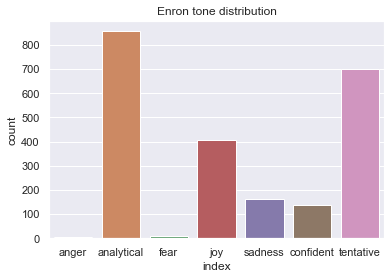

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.barplot(x = vis_ax['index'], y = vis_ax['count'], data=vis_ax).set_title('Enron tone distribution')

In [36]:
# Indent keyword while dumping the
# data decides to what level 
# spaces the user wants.
#print(json.dumps(data_dict, indent = 1))

#print(data_dict['sentences_tone'])

# Difference in the spaces 
# near the brackets can be seen
#print(json.dumps(data_dict, indent = 3))

In [37]:
df_train = pd.read_csv("/Users/siddharthsingh/CadenceIQ/tone_Analyzer/emotions-dataset/train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("/Users/siddharthsingh/CadenceIQ/tone_Analyzer/emotions-dataset/test.txt", delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv("/Users/siddharthsingh/CadenceIQ/tone_Analyzer/emotions-dataset/val.txt", delimiter=';', header=None, names=['sentence','label'])

In [38]:
emo_df = pd.concat([df_train,df_test,df_val])

In [39]:
emo_df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [93]:
emo_df.head(10)

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [41]:
emo_df.describe()

,sentence,label
count,20000,20000
unique,19948,6
top,i resorted to yesterday the post peak day of i...,joy
freq,2,6761


In [62]:
count = emo_df['label'].value_counts()
print(count)
count.sum()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: label, dtype: int64


20000

In [63]:
emo_df1 = emo_df[:1500].copy()

In [64]:
emo_df1.shape

(1500, 2)

In [67]:
emo_df1.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [68]:
emo_df1.describe()

,sentence,label
count,1500,1500
unique,1500,6
top,i know scones are not a must have food but i a...,joy
freq,1,528


In [70]:
count_df1 = emo_df1['label'].value_counts()
print(count_df1)
count_df1.sum()

joy         528
sadness     395
anger       209
fear        174
love        135
surprise     59
Name: label, dtype: int64


1500

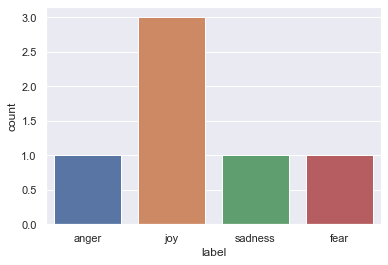

In [71]:
sns.countplot(x=count_df1, data = emo_df1['label'])

## Accessing JSON data to visualize distribution of Emotions dataset tones

In [72]:
#IBM watson tone analyser API endpoint 

authenticator = IAMAuthenticator('SwdiI5vCKkgeyJuYIEwhOkajctEnxTR-F7OYZ4pvF9GE')
tone_analyzer = ToneAnalyzerV3(
    version='2017-09-21',
    authenticator=authenticator
)
tone_analyzer.set_service_url('https://api.us-south.tone-analyzer.watson.cloud.ibm.com/instances/3e193de0-bcaa-47c0-8898-4c68a520ce78')


In [74]:
#Converting column to list. 

text = list(emo_df1['sentence'])
text 

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too',
 'i feel like i have to make the suffering i m seeing mean something',
 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter',
 'i think it s the easiest time of year to feel dissatisfied',
 'i feel low energy i m just thirst

In [78]:
c = 0
list_tones = []


for i in text:
    print(i)
    tone_analysis = tone_analyzer.tone(
        {'text': i},
        content_type='application/json'
    ).get_result()

    list_tones.append(json.dumps(tone_analysis, indent=2))
    c+=1

emo_df1 = emo_df1.assign(tones = list_tones)
#print(json.dumps(tone_analysis, indent=2)) 

i didnt feel humiliated
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
im grabbing a minute to post i feel greedy wrong
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
i am feeling grouchy
ive been feeling a little burdened lately wasnt sure why that was
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny
i feel as confused about life as a teenager or as jaded as a year old man
i have been with petronas for years i feel that petronas has performed well and made a huge profit
i feel romantic too
i feel like i have to make the suffering i m seeing mean something
i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
i think it s the easiest time of year to feel dissatisfied
i feel low energy i m just thirsty
i have immense sympathy with the general point but a

i drove dannika to school i was feeling a little bit rushed and this is what greeted me as i turned the corner
i remember feeling so hellip furious with the shooter
i feel very happy and excited since i learned so many things
i feel that at shows and around show horses people are trusting and relaxed because most show horses are safe and quiet and are handled frequently
i only have a couple of things left to make and at the start of december i am done and feeling smug
i think about how u could make me feel and realize that everything will be ok
i feel so worthless during those times i was struggling finding work
i will be able to lay on my bed in the dark and not feel terrified at least for a while
i was ready to meet mom in the airport and feel her ever supportive arms around me
im feeling bitter today my mood has been strange the entire day so i guess its that
when my mums brother passed away after having been involved in a car accident he was bringing me a present as i had passed my

i could feel her whimper to the thought of being unloved and uncared for
im certainly not going to sit and tell you whats going on in my personal life but i feel that if you were ever curious about whats going in my life all youd have to do is watch the show
im sorry that there wasnt more humor in this post but im not feeling all that funny
i feel ive got my foot in the door of the fantastic world of walking and running the trails fells and mountains
i say whatever comes in my mind tell you directly what i feel a jealous girl not because i m insecure but because i just love that person a trust worthy friend sweet to the one i love
i feel strange coming back to work after my one day holiday
im clearly influenced by the dash happiness of emily dickinson for example and i use dashes instead of colons or semi colons to enhance the feelings of rushed enjambment in the sonnet
i am fatter because the only thing in my life that can remain under my control is whether or not i get to eat peanut 

i feel like that s so weird that i had cancer that one time
i want to feel safe and well and that maybe just maybe theres a small chance my i can feel joy and my dreams can come true
im feeling cranky
i also think it is puzzling that after this particular administrator has singled me out for praise on my ability to get my students to read that he feels that ssr time is not a productive use of class time
i tried to fill it by befriending people that i knew were only using me but i didnt care because i needed to feel accepted even if it was by some complete loser
i feel stressed always
i remember feeling another cramp but i also ignored it
i hope i feel mellow well fed well slept at peace with myself within this external world
i have also learned it takes a lot of effort and positive thinking for me not to break down in tears over feeling exhausted and guilty for not being a better mom
im feeling awful because we hung out with my friend and her new baby the day before
i feel very relaxed

i go up to her and i say feeling very impressed with myself youre naomi klein right
i began to feel each of my senses dull until the cold black unconsciousness over came me
i suspect feel less than fond in private
i was so honoured that this young woman felt comfortable enough to ask me i had kind of a faux hawk thing going on back then so i must have looked dykey enough for her to feel safe talking to me
i do have to wonder when you re cast as a caveman and you re told you re perfect for the part do you feel insulted or complimented
i feel convinced plus so many diverse price tags that i feel sure everyone should come up with the funds to have their plot to be lighted up relatively economically
i feel empty when the baby isnt there
i stopped feeling so exhausted a href http provokingbeauty
im feeling font friendly
i had my hand on my beads consciously breathing consciously working to feel calm about my list of things to accomplish that afternoon
i always feel intimidated by other peop

i didnt feel especially nervous in finland but when we landed in paris i was a little unsure about what would be ahead of us thought st grade student janne suominen
i do feel envious of those with kids at certain moments
i was feeling like a pretty crappy mom
im feeling pissed off about my aac or feeling kind of miserable and frustrated with life this whole week
im not scared at all anymore im fine i feel terrific about the surgery
i still feel vulnerable around him
i honestly am not sure how i feel stunned
i feel when you are a caring person you attract other caring people into your life
im then left feeling quite embarrassed as i say that nothings new
i feel unwelcome and out of place buti cant decide if i am just too scared to do anything about this ok situation or if i am staying here in this dead end situation because i am afraid things will get worse
i may or may not have cried when thanking them for making my children feel so special and loved
i really want to go buy some yardag

ive had a lot of good days where i feel fabulous and have lots of energy but lately ive also had some bad days where i feel gigantic and slow and clumsy
i also feel like if google hated seo we d know it
i didnt get a wink of sleep that night and continued feeling not so fabulous the next morning
i feel like you feel this is a mistake but time is fucked up sleep won t take
i love sliding down on a nice big throbbing cock and feeling what my gorgeous body does to a man
i found myself in the novel position of feeling a bit uncertain about the stock market rally
i feel like she s judging me and he s not here and i don t want to seem like the needy girl so i don t know
im definitely feeling festive
i feel burdened by her presence
i still feel a little dazed and have that sort of disbelieving feeling of oh my god
i am feeling super excited as the weeks seem to be flying by and we are getting closer and closer to our due date
i have turned that page i feel like there is no way of getting back

i can feel but i cant touch you said my love was a bit too much i wont deny it broke my heart cant find no crush so why dont you come on back home
i feel a little frustrated an ache of longing has settled into my heart the weariness of life his slipped around my shoulders like an unwelcome friend
i even remember trying them on last year and feeling crappy because i was nowhere near closing them
i broke my uncles radio player accidentally and so i feared that he was going to cut me off from going to his house as well as playing it again
i have been feeling conflicted on whether or not i as a follower of christ should celebrate the ever popular pagan originated modern day holidays
i was feeling impatient and took pills
i feel carefree and weightless and yet worried and grounded all at the same time
i feel he is sincere and repentant for his past opposition to civil rights
i did at one point put my son in daycare but my mom constantly made me feel like a terrible parent because of it
i on

i feel kind of insecure here anyways back to doha
i am grateful that i no longer feel a frantic urge to fix the emotional upsets of those around me
i feel about strange brew
i feel quite strongly that students should be punished due to how well or badly they have faired compared to a completely unrelated group of people
i want to have a job where i am permanent and where i feel like i am valued
i care about someones emotional spiritual and intellectual progress to the point where i feel like i should exert myself in that progress and its important to me that is love
i will actually feel comfortable speaking to others in just japanese i feel pretty happy about my current progress
i learned about different things like how family plan the arrangements and even how real the pain can feel when a loved one passes on
i feel at least dating them would not be in vain
i like keeping a record of my life in written form and pictures and i feel like that is even more important now that i have baby


im feeling fine
i prep myself for another sleepless night i can t help but feel ashamed of myself for feeling this way
im feeling quite pleased this week
i still feel shaky is because in the worst hit areas the damage and destruction is so complete
i wouldn t throw it in the ocean but i don t feel i would have missed something in my career if i don t win an oscar
i feel privileged to have narrated erik princes autobiography civilian warriors the inside story of blackwater and the unsung heroes of the war on terror which will be released this monday nov th
im not used to feeling the dependency or the neediness for being needy is not me or at least wasnt prior to recently
i am feeling hopeful and looking forward once again
i feel it is because mccarthy isn t at that place yet in her career where she can really consistently humanize a character while balancing out the fact they are supposed to be funny
i feel uncertain and uneasy
i feel so comfortable around him
i feel privileged having t

i feel so numb f
i sit here tonight i m pensive tense and feeling a little fearful
i want someone i know to know all my thoughts and feelings or do i want to keep all my loyal and faithful readers
i feel more joy and anticipation of all that is my divine right
i was feeling so overwhelmed that i asked my bqff to keep of them at her house until theyre ready to be loaded so i dont feel so behind
i feel thrilled to be able to investigate my own personal mythology around this subject
i feel creative right now and it makes me happy
i could wear on a casual shopping trip to feel fabulous without even trying
i want others to be happy but does that mean i step back yet again it feels like and allow them to be happy because they deserve it or do they even deserve it or do i
i am limiting myself to what i can reasonably do without causing greater injury but i have to do some sort of physical exercise or i start to feel horrible about myself
i would always feel amazed at how impacted these and ye

i do not feel insecure or unsafe
i feel sort of pathetic saying that my iphone internet and tv are my must haves but lets be honest they are
i guess while i can understand their concern i can t help but feel a little rejected
i laced my shoes and pounded out those feelings on the hot black pavement before me
i male are stupid first for woman cry babies and should get over it and you feel really cool for putting the stupid men in their place
i think that our favorite activities as a child are often very telling and if someone is feeling a little unsure about their life s direction going back to those childhood favorite past times holds many rich clues
i took to be his son joined elihu and me at christmastime inside a fine home with lovely mill work darkly lit and with a large stately christmas tree in the living room the feeling was gentle it was one of long lost friends meeting for the first time as adults as people
i have been praying everyday about it and i just feel more and more co

i feel defeated like a lion s prey
i like him for who he is or i just like the feeling to be liked
i am excited i hope they will be a it more personal with us and i wont feel like i am being rushed in and out
i surround myself with bible verses that help me to transcend to a space where i feel safe and secure
i don t know why it is that i feel awkwardly hesitant to return to melbourne
i feel a little less gloomy a little more optimistic or a little better prepared to face what life throws my way
i wont lie im a little worried and nervous and i feel inadequate for the job but ill just do my best thats all my heavenly father wants of me
i slough off the carapace of crud that has enveloped me for the past thirty odd hours i feel invigorated and finally ready to face the day
ive been a busy girl but it has been a very good type of busy and im feeling really happy about things right now and i am loving my new start in glasgow
when my mother kept me in leadingstrings
i set my mind to wanting

i felt better on thursday and today friday felt good enough to come into work though i still feel kind of shitty and foggy
i just feel disappointed for losing he said
i need to get in touch with what i want and how i want to feel did i mention how much i hate people caring for me
i feel like a failure of a parent which add that to the emotional rollercoaster of having to have an unplanned c section and well some days i feel like i have just failed from the beginning
i feel rather intimidated by my re his impressive background and the clinic in general
i secretly well i guess not secretly anymore feel insecure about this but at the same time want them to learn how to come up with common ground by themselves
i need to feel assured i need to feel secure
i could genuinely feel loving toward someone without them ever knowing it if i dont act like it
i feel like the people that disliked it the most
i can never seem to get on the good foot and i feel so crappy
i want something that gives me a

i wanted to go and ask him about my batting but was feeling hesitant about approaching such a big player
i got a bit caught up in the moment and forgot that at the core of the rude comments and silly songs were the real feelings of a beloved and brilliant comic actor and a very sweet and big hearted young woman
ive been feeling a bit overwhelmed with the whole marathon idea lately
i know i would feel weird about that and probably act strangely for a few days
i feel like an impostor in my work as i smile and talk about behavior contracts positive reinforcement cognitive reframing physical activity and other means for diminishing dissolving or deferring the pain of reality
i feel suspicious if there is no one outside like the rapture has happened or something
i feel so deeply shocked and saddened
i did manage two short runs and a walk but today im back to feeling just shy of awful
im told by horsey people that they are a rare find so i feel quite lucky
i have not spent that much time wit

i didnt feel that there were enough strong smart and funny female main characters in fiction and since thats what i imagine myself to be i started writing
i would just go to the straight point rather than doing a defination of such as what is romance feeling or anger feeling or suspicious feelings
i wasnt feeling casual much
i feel slightly emotional watching it
i feel like i ve regained another vital part of my life which is living
i went up to the teacher and said im gonna step outside for a second im really not feeling too well
i pray that each of you who is hurting or feeling afraid tonight finds peace and soon
i could feel myself getting that shaky feeling
i feel more crucified heartbroken tortured and forsaken than i have ever before felt but not at the hands of my enemy at the hands of those i love
i feel like he was more important to me than i thought he was
i believe its possible to be joyful and full of thanks while feeling overwhelmed and exhausted by life
i want people to f

i feel like a post might be devoted to dealing with emotions caused by situations vs
i flung into my suitcase at the last minute didn t break on the crossing over or explode in the pressurized cabin so thus far i m feeling pretty splendid about things
i need to listen to a song where i can be angry and feel accepted at the same time
i find myself seeking and yearning for love and acceptance from people that can not provide it and then being disappointed when i am alone and feeling unloved and unworthy
i feel accepted and appreciated by my teammates and peers
i know that feeling for sure
i was left feeling bothered by it for a long time afterwards
i feel like hopeless helpless worthless scum
i feel so blessed to have both lisa and god as friends in this life
i stopped feeling bitter and sorry for myself and lost myself in the work my work started getting better or rather continued to get better
i am still feeling a little remorseful that we didnt just break down and buy it
i feel more a

i could also feel very bad about myself for not being able to keep up
i feel scared and stupid
i feel like our relationship revovles around sex and when we do he wants it to be really adventurous trying new things using toys etc ansi just find it exhausting trying to keep up
i try to feel confident about it but when ever our eyes meet i feel strong like in gym we have the exercise machines and i could only do lbs on average and i always wanted to do
i feel about them i still end up nervous and have those naughty butterflies flying around my stomach
i am feeling very anxious about going to therapy w
i feel angry thinking how much the government has gulped away over money
i am feeling a bit adventurous i put on red lipstick rouge artist and intense from make up for ever
i have no idea why this particular region seems to lack a visibly necessary outer carniola as well and i feel actually somewhat bothered by this possible evidence of lack of suburban spirit
im putting it in my palm and bl

i feel as though you are determined to annoy me you know i dont want you listening to the radio
i feel like i ll never be as graceful an
i am feeling stressed
i don t feel super strongly about it
i can feel the cold of winter
i feel and look gorgeous beautiful and sexy
im feeling all triumphant you may high five me if you choose mind you ill laugh at you but
i can no longer wear my t shirts without feeling like i m supporting a totally different band
ive been without a home without somewhere that i feel truly welcomed and safe
i feel more in control and less frightened about my headaches and migraine attacks excellent service
i am feeling extremely contented with our decision to home educate
i guess the trick is i need to go in strong and get what i want and not feel bashful over it
i was a bit too nervous to focus on the faces and the feeling was not unpleasant i wanted to put in a joke to start with especially since it involved the key note speaker and i thought it was funny
im start

In [97]:
emo_df1.head(10)

,sentence,label,tones
0,i didnt feel humiliated,sadness,"{\n ""document_tone"": {\n ""tones"": [\n ..."
1,i can go from feeling so hopeless to so damned...,sadness,"{\n ""document_tone"": {\n ""tones"": [\n ..."
2,im grabbing a minute to post i feel greedy wrong,anger,"{\n ""document_tone"": {\n ""tones"": [\n ..."
3,i am ever feeling nostalgic about the fireplac...,love,"{\n ""document_tone"": {\n ""tones"": [\n ..."
4,i am feeling grouchy,anger,"{\n ""document_tone"": {\n ""tones"": [\n ..."
5,ive been feeling a little burdened lately wasn...,sadness,"{\n ""document_tone"": {\n ""tones"": [\n ..."
6,ive been taking or milligrams or times recomme...,surprise,"{\n ""document_tone"": {\n ""tones"": [\n ..."
7,i feel as confused about life as a teenager or...,fear,"{\n ""document_tone"": {\n ""tones"": [\n ..."
8,i have been with petronas for years i feel tha...,joy,"{\n ""document_tone"": {\n ""tones"": [\n ..."
9,i feel romantic too,love,"{\n ""document_tone"": {\n ""tones"": [\n ..."


In [99]:
emo_df1['sentence'][9]

'i feel romantic too'

In [101]:
emo_df1['tones'][7]

'{\n  "document_tone": {\n    "tones": [\n      {\n        "score": 0.707291,\n        "tone_id": "sadness",\n        "tone_name": "Sadness"\n      },\n      {\n        "score": 0.954099,\n        "tone_id": "tentative",\n        "tone_name": "Tentative"\n      }\n    ]\n  }\n}'

In [102]:
emo_df1['tones'].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

In [103]:
emo_df1['tones'][7]

'{  "document_tone": {    "tones": [      {        "score": 0.707291,        "tone_id": "sadness",        "tone_name": "Sadness"      },      {        "score": 0.954099,        "tone_id": "tentative",        "tone_name": "Tentative"      }    ]  }}'

In [104]:
emo_df1.to_csv(r'/Users/siddharthsingh/CadenceIQ/tone_Analyzer/Emotions-tone-data-og.csv')

In [107]:
json_df1 = emo_df1['tones'].to_json(r'/Users/siddharthsingh/CadenceIQ/tone_Analyzer/emotions-tones.json')

In [108]:
counter_dict_df1 = {
    
        'anger' : {
            'score' : 0,
            'count' : 0
        }, 
        'analytical' : {
            'score' : 0,
            'count' : 0
        },
        'fear' :{
            'score' : 0,
            'count' : 0
        },
        'joy' : {
            'score' : 0,
            'count' : 0
        },
        'sadness' : {
            'score' : 0,
            'count' : 0
        },
        'confident' : {
            'score' : 0,
            'count' : 0
        },
        'tentative' : {
            'score' : 0,
            'count' : 0
        }
}

for json_df1 in emo_df1['tones']:
    data_dict_df1 = json.loads(str(json_df1))
    
    for document_tones_df1 in data_dict_df1['document_tone']['tones']:
        counter_dict_df1[document_tones_df1['tone_id']]['count']+=1
        counter_dict_df1[document_tones_df1['tone_id']]['score']= (counter_dict_df1[document_tones_df1['tone_id']]['score'] + document_tones_df1['score'])/2

print(counter_dict_df1)

{'anger': {'score': 0.8169358478850066, 'count': 65}, 'analytical': {'score': 0.6774187241612544, 'count': 486}, 'fear': {'score': 0.6939395931996024, 'count': 88}, 'joy': {'score': 0.809484227948831, 'count': 425}, 'sadness': {'score': 0.5923032265169048, 'count': 473}, 'confident': {'score': 0.6064177371491613, 'count': 133}, 'tentative': {'score': 0.9124142916008007, 'count': 588}}


### Visualizing Emotions tones

In [113]:
#The dictionary of tones, count & score converted to DATAFRAME for visualization

vis_df1 = pd.DataFrame.from_dict(counter_dict_df1)
vis_ax1 = vis_df1.transpose()
vis_ax1.reset_index(level=0, inplace=True)
print(vis_ax1)
vis_ax1['count'].sum()

        index     score  count
0       anger  0.816936   65.0
1  analytical  0.677419  486.0
2        fear  0.693940   88.0
3         joy  0.809484  425.0
4     sadness  0.592303  473.0
5   confident  0.606418  133.0
6   tentative  0.912414  588.0


2258.0

Text(0.5, 1.0, 'Emotions tone distribution')

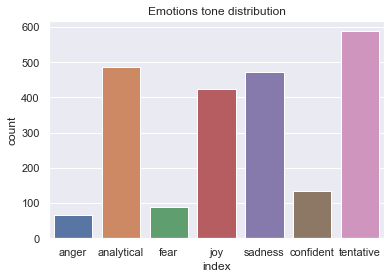

In [115]:
sns.barplot(x = vis_ax1['index'], y = vis_ax1['count'], data=vis_ax1).set_title('Emotions tone distribution')